In [1]:
from datasets import get_dataset

2022-12-27 17:10:39.918906: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/lib:/cluster/apps/gcc-8.2.0/libsndfile-1.0.28-i77pq6lxe4k3rsu447xztnm7lpky4xln/lib:/cluster/apps/gcc-8.2.0/nccl-2.11.4-1-pwkiz23vbeac3vt5ykybdwzaykprizb2/lib:/cluster/apps/gcc-8.2.0/cudnn-8.2.1.32-yqvbgr3teq3v6xu5eyc75xhbl2ya343j/lib64:/cluster/apps/gcc-8.2.0/cuda-11.3.1-o54iuxgz6jm4csvkstuj5hjg4tvd44h3/lib64:/cluster/apps/gcc-8.2.0/openblas-0.3.15-huwxbhezdzoo74awrgoz6sd2qndpmdva/lib:/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64:/cluster/spack/apps/linux-centos7-x86_64/gcc-4.8.5/gcc-8.2.0-6xqov2fhvbmehix42slain67vprec3fs/lib64:/cluster/spack/apps/linux-centos7-x86_64/gcc-4.8.5/gcc-8.2.0-6xqov2fhvbmehix42slain67vprec3fs/lib:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/lib::


In [2]:
from configs.poisson.audio_ddpmpp import get_config

In [3]:
config = get_config()

In [4]:
trainds, evalds, builder = get_dataset(config)

2022-12-27 17:10:44.386312: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-27 17:10:44.475918: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [9]:
import matplotlib.pyplot as plt

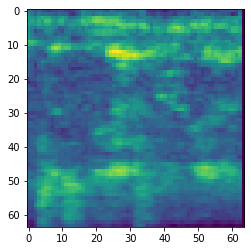

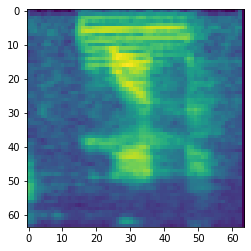

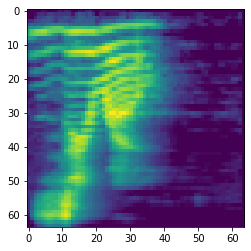

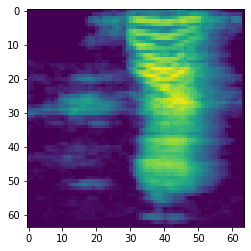

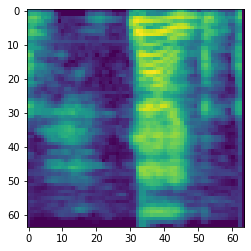

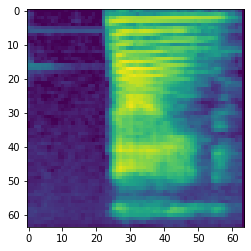

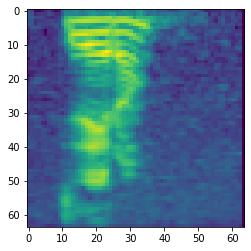

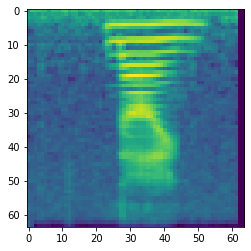

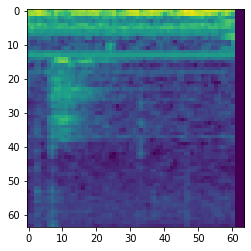

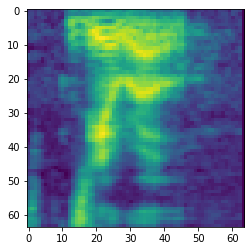

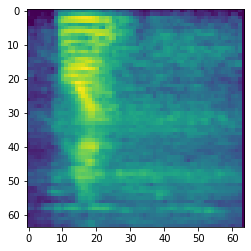

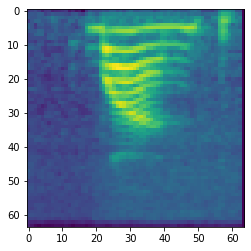

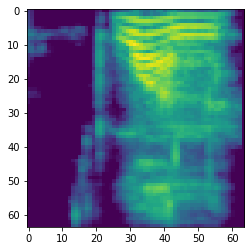

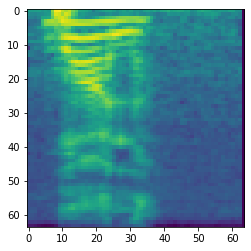

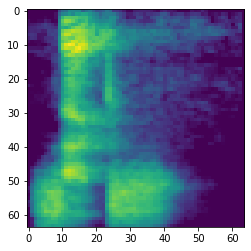

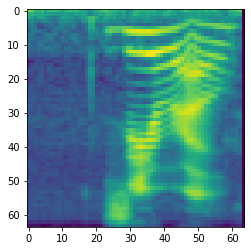

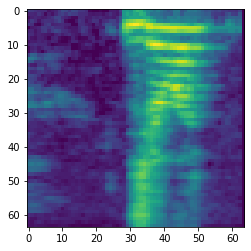

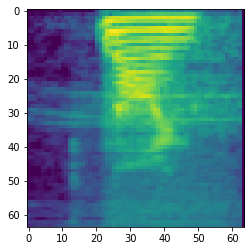

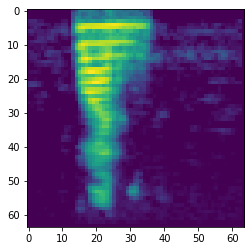

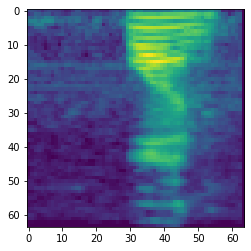

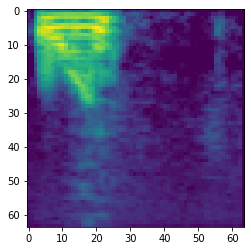

In [15]:
for i, item in enumerate(trainds):
    if i>20: break
    plt.figure()
    plt.imshow(item['image'][0][0])
    plt.show()